## Import libraries

In [1]:
import pandas as pd
from langdetect import detect
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from pathlib import Path

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## clean up scraped data

In [4]:
df = pd.read_csv("../data/0_raw/medium.csv", parse_dates=["date"])
df["claps"] = df["claps"].apply(lambda x: int(float(x.replace("K", "")) * 1000) if "K" in x else int(x))

## clean up export data

In [25]:
# parse claps as integer on read
_df = pd.read_csv("../data/export.csv")
# lowercase column names
_df.columns = _df.columns.str.lower()
# join year month day column into one
_df["date"] = _df["year"].astype(str) + "-" + _df["month"].astype(str) + "-" + _df["day"].astype(str)
# rename reading_time to read_time
_df.rename(columns={"reading_time": "read_time"}, inplace=True)
# drop subtitle, image, and year month day columns, and comment and author url 
_df.drop(columns=["subtitle", "image", "year", "month", "day", "comment", "author_url"], inplace=True)
# reorder columns 
_df = _df[['title', 'claps', 'read_time', 'author', 'publication', 'url', 'date','tag']]
# replace _ to - in tag column
_df["tag"] = _df["tag"].str.replace("_", "-")
# parse claps as integer
_df["claps"] = _df["claps"].apply(lambda x: int(float(x.replace("K", "")) * 1000) if "K" in x else int(x))
# convert date to datetime
_df["date"] = pd.to_datetime(_df["date"])

## Join the two datasets

In [26]:
# concat dataframes
df = pd.concat([df, _df], ignore_index=True)

## Remove duplicates

In [27]:
print(df.shape)
df = df.drop_duplicates(subset=["title"])
# reset index
df.reset_index(drop=True, inplace=True)
print(df.shape)

(323218, 8)
(226468, 8)


## drop missing titles

In [28]:
df.isnull().sum()

title               1
claps               0
read_time           0
author            710
publication    125072
url                 0
date                0
tag                 0
dtype: int64

In [29]:
df = df.dropna(subset=["title"])
df = df[df["title"] != " "]

## filter only english

In [31]:
def detect_lang(title):
    try:
        return detect(title)
    except:
        return "unknown"

df = df[df["title"].parallel_apply(lambda x: detect_lang(x) == "en")]

## EDA

In [ ]:
df.to_parquet("../data/1_interim/clean_df.parquet", index=False)

In [2]:
df = pd.read_parquet("../data/1_interim/clean_df.parquet")

In [3]:
df = df[["title", "claps"]]
df

,title,claps
0,The ugly truth about the model industry,5
1,2016 United States of Technology,3
2,Side-effects of Python Machine Learning,7
3,Demystifying Big Data Infrastructure,0
4,A Closer Look at the NBAs Last Two Minute Repo...,3
...,...,...
194840,Blockchain Investment Trends Review | Blog 1,0
194841,Hbase master.HMaster: Failed to become active ...,0
194842,Safe Stock Concept,0
194843,How data virtualisation could help to mitigate...,0


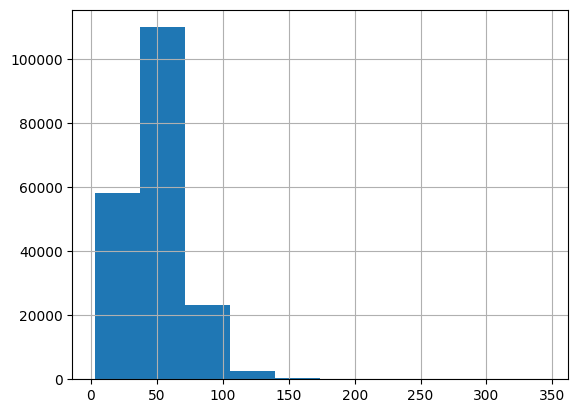

In [4]:
# distribution of title length
df["title"].str.len().hist()

plt.savefig("../reports/figures/title_length.png")

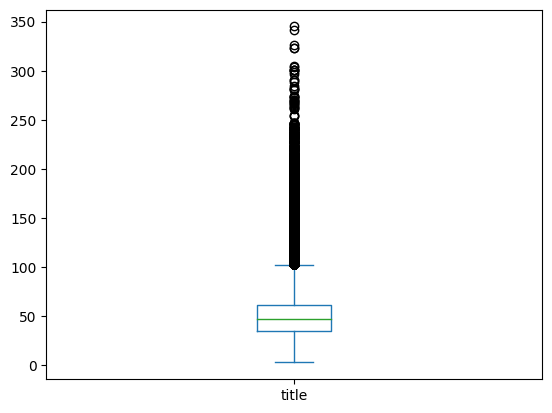

In [5]:
# box plot of title length
df["title"].str.len().plot.box()

plt.savefig("../reports/figures/title_length_box.png")

In [6]:
df["title"].str.len().describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    194845.000000
mean         50.223881
std          21.882779
min           3.000000
10%          26.000000
25%          35.000000
50%          47.000000
75%          62.000000
90%          76.000000
max         345.000000
Name: title, dtype: float64

In [7]:
df[df["title"].str.len() == 30].title.sample(10).values

array(['Random ForestSturdy algorithm.', 'A Brave WorldA Browser for Now',
       'Population Mean Vs Sample Mean', 'First Step to Machine Learning',
       'Feature generation from tweets', 'Skafos SDK v0.2.1 is Now Live!',
       'Talking Data User Demographics', 'Looking Ahead with More Steps!',
       'Atomic Design: Getting Started', 'Time Series Analysis in Python'],
      dtype=object)

In [8]:
df[df["title"].str.len() == 70].title.sample(10).values

array(['Automating Your ML Models Like a Pro Using AirFlow, SAS Viya, & Docker',
       'Why Bother Deploying a Huge Neural Model when the Small One is Enough?',
       'Delving into Federated LearningA Decentralized Training Approach in ML',
       'NodeJS vs Java! An epic battle, which is going to rule in 2020! Part 2',
       'Airbnb listings Data Analysis: A westcoast versus eastcoast comparison',
       'Which Skills Do You Need for LinkedIns Emerging Job List? An Analysis.',
       'Build your own custom hotword detector with zero training data and $0!',
       'ROYBI Acquires KidSense.AI, The Leading Speech Recognition AI Platform',
       'Automated meteor/aircraft/satellite detection for sky camera in Python',
       'Introduction to machine learning,deep learning,artificial intelligence'],
      dtype=object)

In [9]:
# filter a title within +- 20 characters of the average title length
df = df[df["title"].str.len().between(30, 70)]

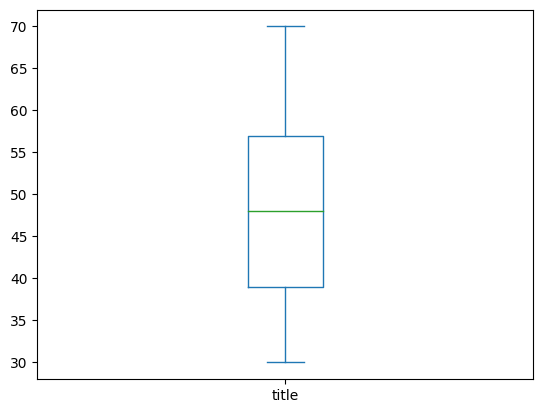

In [10]:
# boxplot of title length
df["title"].str.len().plot.box()

plt.savefig("../reports/figures/title_length_box_filtered.png")

remove titles with "->" to avoid confusion with the prompt

In [11]:
# remove titles with "->" to avoid confusion with the prompt
df[df["title"].str.contains("->")]

,title,claps
2579,Ordering a python list -> the simple way,0
6630,->PSql termed as #PostgreSql,2
9494,DevTip 1: Cache -> Invalidation,0
21816,Data Science for Startups: R -> Python,1700
26616,This weeks Tech Smart Boss Cool Tech of the W...,0
28129,This weeks Tech Smart Boss Cool Tech of the W...,0
32346,This weeks Tech Smart Boss Cool Tech of the W...,0
40712,How to Reverse a Linked List Recursively -> an...,5
42823,This weeks Tech Smart Boss Cool Tech of the W...,0
76549,This weeks Tech Smart Boss Cool Tech of the We...,0


In [12]:
df = df[~df["title"].str.contains("->")]

In [19]:
df.shape

(137904, 2)

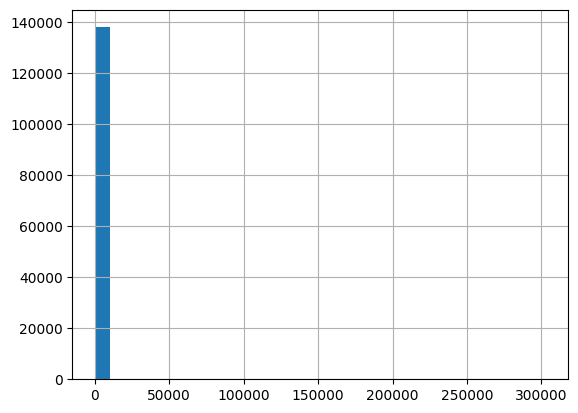

In [13]:
# distribution of claps
df["claps"].hist(bins=30)

plt.savefig("../reports/figures/claps.png")

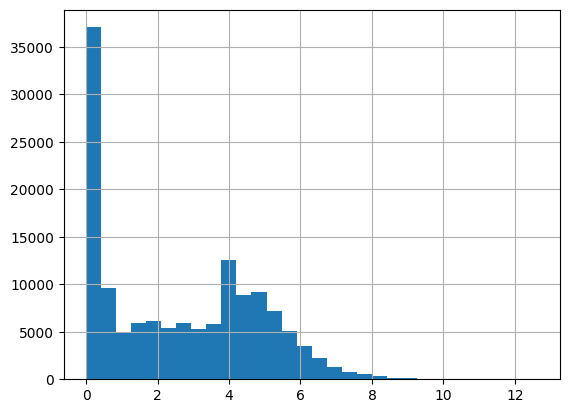

In [14]:
# log distribution of claps
import numpy as np

df["claps"].apply(lambda x: np.log1p(x)).hist(bins=30)

plt.savefig("../reports/figures/claps_log.png")

In [15]:
df.claps.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    137904.000000
mean        125.231255
std        1129.071139
min           0.000000
10%           0.000000
25%           0.000000
50%          11.000000
75%          83.000000
90%         240.000000
max      303000.000000
Name: claps, dtype: float64

In [16]:
df["claps"].median()

11.0

In [17]:
# filter claps >= 10
df = df[df["claps"] >= 10]

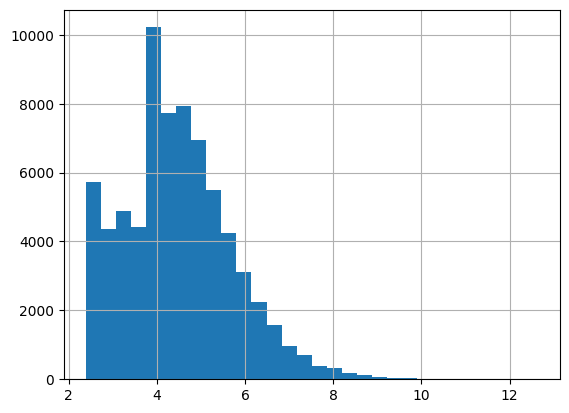

In [18]:
df["claps"].apply(lambda x: np.log1p(x)).hist(bins=30)

plt.savefig("../reports/figures/claps_log_filtered.png")

In [28]:
df.shape

(71753, 2)

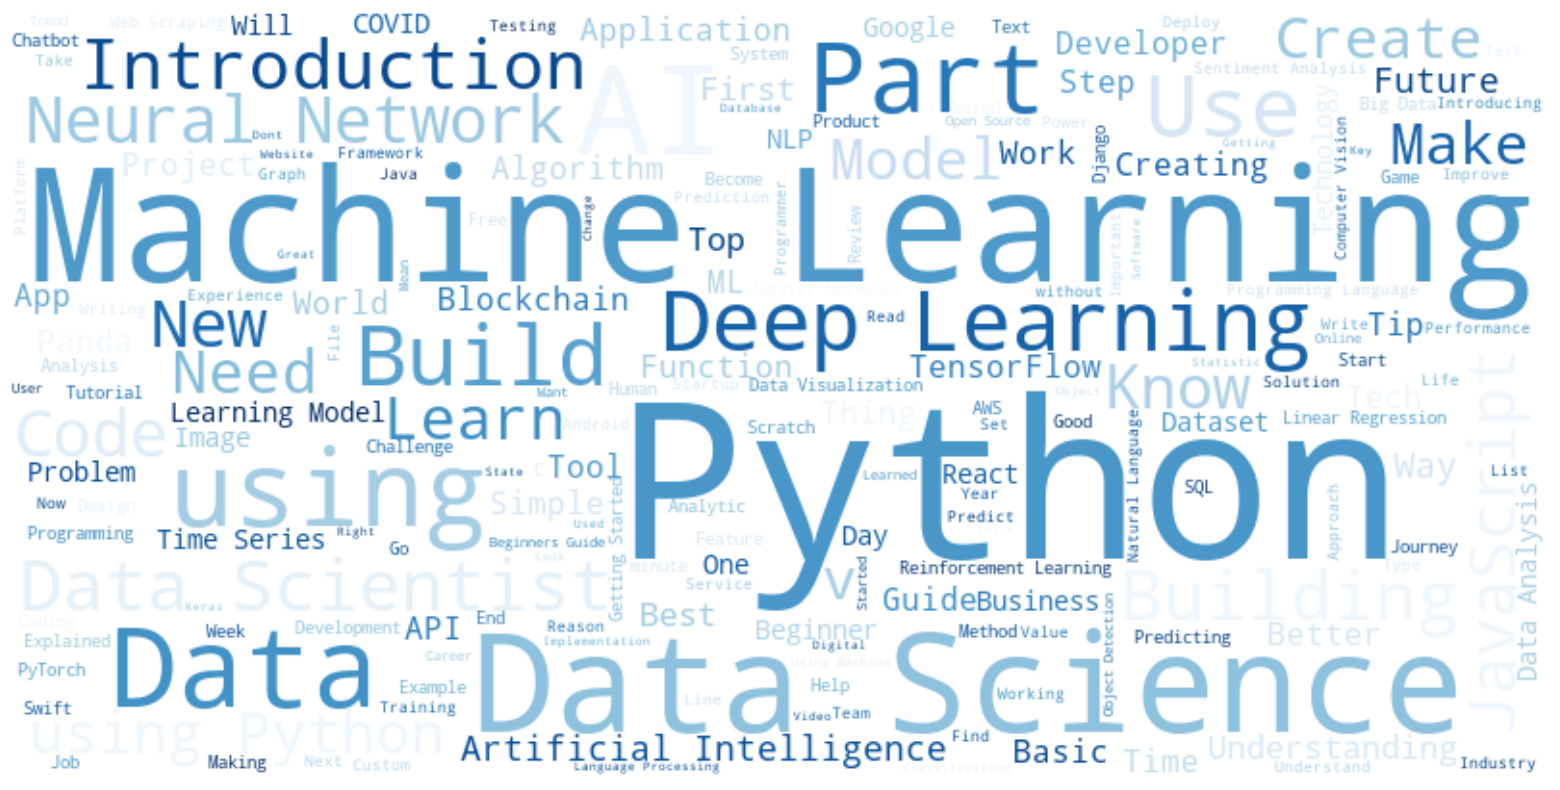

In [23]:
# wordcloud of titles
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(" ".join(df["title"]))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../reports/figures/wordcloud.png")

/Users/benedictneo/miniforge3/envs/gpt3-blog/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


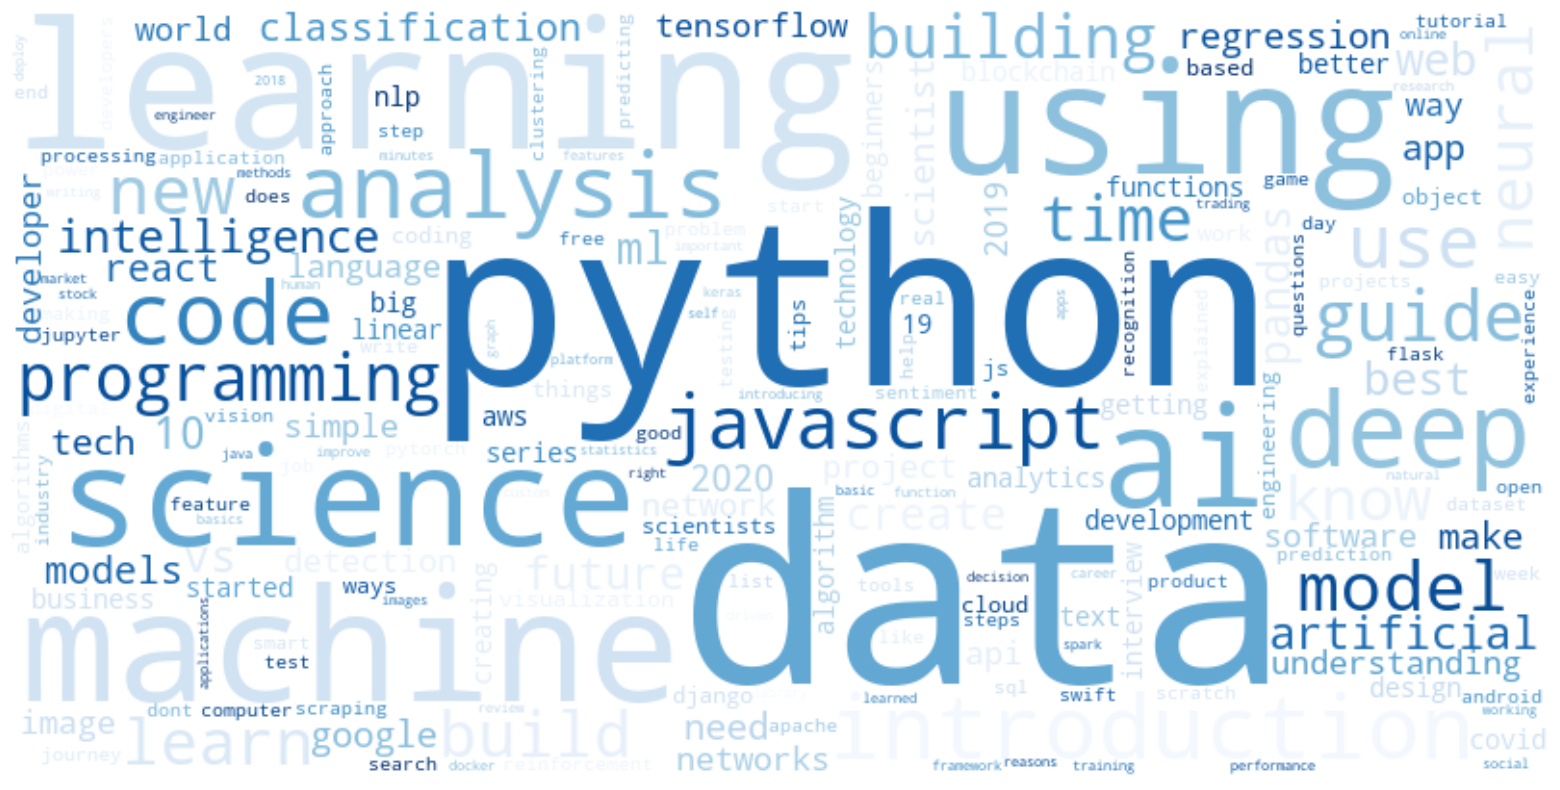

In [22]:
# word cloud with tfidf

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf.fit(df["title"])

tfidf_df = pd.DataFrame(tfidf.transform(df["title"]).todense(), columns=tfidf.get_feature_names())

tfidf_df.sum().sort_values(ascending=False).head(20)

# use better color scheme
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate_from_frequencies(tfidf_df.sum())

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.savefig("../reports/figures/wordcloud_tfidf.png")

## figure out the right cutoff point

In [25]:
print(df[df["claps"] >= 100].shape)
print(df[df["claps"] >= 130].shape)
print(df[df["claps"] >= 150].shape)
print(df[df["claps"] >= 200].shape)

(31310, 2)
(24695, 2)
(22049, 2)
(16710, 2)


Let's use 200 as the cutoff point

In [26]:
df.to_csv("../data/2_final/final_df.csv", index=False)